In [0]:
# getting the data
import torchvision
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

# exmaple from https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self, activation):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 64)
        self.fc2 = nn.Linear(64, 10)
        if activation == 'relu':
            self.activations = F.relu
        else: # softmax
            self.activations = F.softmax

    def forward(self, x):
        x = self.activations(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.activations(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = self.activations(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return correct / len(test_loader.dataset)

  

In [0]:
!pip install scikit-optimize

In [0]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

from skopt.plots import *


In [0]:

dim_num_batch_size_to_base = Integer(low=2, 
                                     high=7, 
                                     name='log_batch_size')
dim_learning_rate = Real(low=1e-6, high=1e0,
                         prior='log-uniform',
                         name='lr')
dim_activation = Categorical(categories=['relu', 'sigmoid'], 
                             name='activation')
dimensions = [dim_num_batch_size_to_base,
              dim_learning_rate,
              dim_activation]

default_parameters = [4, 1e-1, 'relu']


In [0]:
@use_named_args(dimensions=dimensions)
def main(log_batch_size=6, lr=1e-2, activation='relu'):
    # Training settings
    class Args:
        seed = 0
        test_batch_size = 1000
        epochs = 10
        momentum = 0.5
        log_interval = 15000
        def __init__(self,
                     log_batch_size, 
                     lr, 
                    activation):
            self.activation = activation
            self.batch_size = int(2**log_batch_size)
            self.lr = lr
        def __repr__(self):
            return str(self.__dict__)
    
    args = Args(log_batch_size,lr,activation)
    
    torch.manual_seed(args.seed)

    kwargs = {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    device = 'cuda'
    model = Net(args.activation).to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    print ('Args for this run:')
    print (args)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        finalacc = test(args, model, device, test_loader)
    
    return -finalacc # we will be miniming using scikit-optim

In [0]:
import pickle

In [0]:
meth = "EI"
search_result = gp_minimize(func=main,
                            dimensions=dimensions,
                            acq_func=meth,
                            n_calls=11,
                            x0=default_parameters)

with open(f'dump{meth}.pkl', 'wb')as f:
    pickle.dump(search_result, f)

Args for this run:
{'activation': 'relu', 'batch_size': 16, 'lr': 0.1}
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306580

Test set: Average loss: 0.0706, Accuracy: 9806/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023539

Test set: Average loss: 0.0769, Accuracy: 9791/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.065227

Test set: Average loss: 0.0906, Accuracy: 9768/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.665407

Test set: Average loss: 0.0808, Accuracy: 9796/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.003527

Test set: Average loss: 0.1118, Accuracy: 9726/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.021806

Test set: Average loss: 0.1145, Accuracy: 9772/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.005830

Test set: Average loss: 0.2506, Accuracy: 9584/10000 (96%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000772

Test set: Average loss: 0.1999, Accuracy: 9602/10000 (96%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.022891

Test set: Average loss: 0.2854, Acc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 2.3050, Accuracy: 982/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.297998

Test set: Average loss: 2.3050, Accuracy: 982/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.308806

Test set: Average loss: 2.3050, Accuracy: 982/10000 (10%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.272793

Test set: Average loss: 2.3050, Accuracy: 982/10000 (10%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.306485

Test set: Average loss: 2.3050, Accuracy: 982/10000 (10%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.294720

Test set: Average loss: 2.3049, Accuracy: 982/10000 (10%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.300804

Test set: Average loss: 2.3049, Accuracy: 982/10000 (10%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 2.289621

Test set: Average loss: 2.3049, Accuracy: 982/10000 (10%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 2.309064

Test set: Average loss: 2.3049, Accuracy: 982/10000 (10%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 2.322193

Test set: Average loss: 2.3049, Accuracy: 982/10000 (

In [0]:
# import pickle
# with open('dump2.pkl', 'rb') as f:
#     q = pickle.load(f)

# print(q)

In [0]:
import os
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.special import ndtr
from scipy.stats import norm

In [0]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


plt.style.use('seaborn-paper')
# %matplotlib inline

# fig, ax = plt.subplots(figsize=(16, 6))
# ax = plot_convergence(search_result, ax=ax)
# plt.savefig(f"conv{meth}.svg", ax=ax)
# ax.set_ylabel(r"min $f(x)$ after $n$ queries")


In [35]:
fun = np.array(search_result.func_vals) * -1
fun


array([0.1028, 0.0982, 0.1135, 0.1135, 0.4635, 0.1135, 0.9569, 0.0982,
       0.0982, 0.9909, 0.9494])

In [36]:
out = []
for a in range(len(fun)):
  out.append(np.max(fun[:a+1]).item())
 
out

[0.1028,
 0.1028,
 0.1135,
 0.1135,
 0.4635,
 0.4635,
 0.9569,
 0.9569,
 0.9569,
 0.9909,
 0.9909]

In [0]:
def nnsvm(rcParams, i=0):
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = 'Ubuntu'
    rcParams['font.monospace'] = 'Ubuntu Mono'
    rcParams['font.size'] = 12 + i
    rcParams['axes.labelsize'] = 12 + i
    rcParams['axes.labelweight'] = 'normal'
    rcParams['xtick.labelsize'] = 10 + i
    rcParams['ytick.labelsize'] = 10 + i
    rcParams['legend.fontsize'] = 12 + i
    rcParams['figure.titlesize'] = 14 + i
    rcParams['lines.linewidth']= 2.7
nnsvm(plt.rcParams, i=-4)

In [0]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
        
    ax.grid(alpha=.25)

    return ax

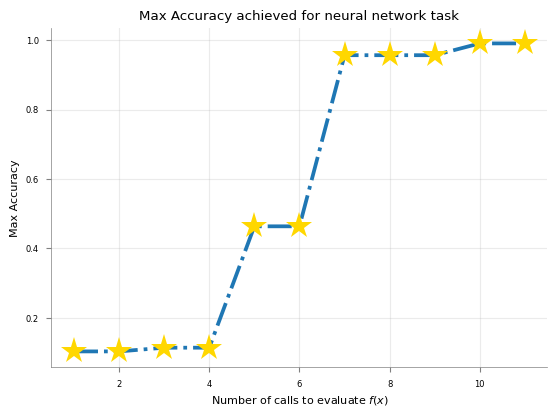

In [39]:
plt.plot(range(1, len(out)+1), out, mfc='gold', marker='*', markersize=20, linestyle='-.', lw=2.7)
plt.ylabel(r'Max Accuracy')
plt.xlabel(r'Number of calls to evaluate $f(x)$')
plt.title('Max Accuracy achieved for neural network task')
format_axes(plt.gca())
plt.savefig(f"conv.svg", bbox_inches="tight")
plt.show()

In [0]:
with open('dumpEI.pkl', 'rb') as f:
  w = pickle.load(f)

In [0]:
w